In [1]:
# Importing libraries

import csv
import os
import pydotplus
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import math
from sklearn.tree import export_graphviz
from io import StringIO
import io
import imageio
from matplotlib import pyplot as plt

In [2]:
# Label Encoders to convert each qualitative variable into a quantitave variable

le = preprocessing.LabelEncoder()
le_gender = preprocessing.LabelEncoder()
le_rvsp = preprocessing.LabelEncoder()
le_rv_function = preprocessing.LabelEncoder()
le_size = preprocessing.LabelEncoder()
le_intervention = preprocessing.LabelEncoder()
le_sloe = preprocessing.LabelEncoder()

In [3]:
# Establishing Random Forest Classifier and MinMaxScalar to normalize all features

model = RandomForestClassifier(n_estimators=10)
scaler = MinMaxScaler(feature_range=(0, 1))

In [4]:
# Function to parse data from csv into a list

def get_data(filename):
    with open(filename, "rt", encoding='utf8') as f:
        reader = csv.reader(f)
        next(reader, None)
        file = csv.reader(f)
        temp = list(file)
    return temp

In [5]:
# Function to output list to csv

def to_csv(filename, nested_list):
    with open(filename, 'w', newline='\n', encoding='utf-8'):
        output_array = np.array(nested_list)
        np.savetxt(filename, output_array, delimiter=",")

In [6]:
# Function to remove 'N/A' From feature columns and replace with mean

def clean_and_mean(lists):
    lists = lists.replace('N/A', np.NaN)
    num_lists = lists.apply(pd.to_numeric, errors='coerce')
    cleaned_lists = num_lists.apply(lambda x: x.fillna(x.mean()))
    return(np.array(cleaned_lists))

In [7]:
# Function to output random forest decision trees into a visual graph using graphviz

def show_tree(decisionTree, file_path, cols, x, y):
    dotfile = io.StringIO()
    export_graphviz(decisionTree, out_file=dotfile, feature_names=cols)
    pydotplus.graph_from_dot_data(dotfile.getvalue()).write_png(file_path)
    i = imageio.imread(file_path)
    plt.figure(figsize = (x,y))
    plt.imshow(i)

In [8]:
# Establishing feature columns and associated headers

included_cols = [3, 4, 5, 6, 7, 8, 9, 10, 19,
    20, 21, 22, 23, 25, 26, 27, 28, 29, 30]

cols = ['Sex (M/F)',
                'BMI',
                'DM (1/0)',
                'HTN (1/0)',
                'COPD (1/0)',
                'CTEPH (1/0)',
                'ESRD (1/0)',
                'Hx of Malignancy (1/0)',
                'Original EDA  (cm2)',
                'Original ESA (cm2)',
                ' Original FAC (%)',
                'Original EndoGLS (%)',
                'Size/Location of Embolus',
                'RVSP',
                'RV Size',
                'RV Function',
                'McConnell\'s Sign',
                'TR Velocity',
                'Intervention']

In [9]:
# Function to seperate features and labels. The label_column defines the expected output in terms of suprevised learning. 
# In this example, column 42 is used which is 'Death Within 1 Year'

def seperate_features_and_labels(file, label_column):
    features = []
    labels = []
    for row in file:
        filt_row = list(row[i] for i in included_cols)
        features.append(filt_row)
        labels.append(row[label_column])

    labels_encoded = le.fit_transform(labels)

    # print(len(cols))
    df_features = pd.DataFrame(features, columns=cols)
    df_features['Sex (M/F)'] = le_gender.fit_transform(df_features['Sex (M/F)'])
    df_features['RVSP'] = le_rvsp.fit_transform(df_features['RVSP'])
    df_features['RV Size'] = le_size.fit_transform(df_features['RV Size'])
    df_features['RV Function'] = le_rv_function.fit_transform(
        df_features['RV Function'])
    df_features['Intervention'] = le_intervention.fit_transform(
        df_features['Intervention'])
    df_features['Size/Location of Embolus'] = le_sloe.fit_transform(
        df_features['Size/Location of Embolus'])

    df_features.to_csv(r'df_features.csv')

    cleaned_features = scaler.fit_transform(clean_and_mean((df_features)))
    return(cleaned_features, labels_encoded)

In [10]:
# Passing data file, seperating features and labels and outputting to csv

data = get_data('scar_data.csv')
f, l = seperate_features_and_labels(data, 42)
to_csv('Features.csv', f)
to_csv('Labels.csv', l)

In [11]:
# 10-Fold Cross Validation. Data is split randomly ten times into test and train data respectively.
# The error is outputted and the mean of the errors is outputted.

scores = []
splits = 10
cv = KFold(n_splits=splits, shuffle=True)
for train_index, test_index in cv.split(f):

    x_train, x_test, y_train, y_test = f[train_index], f[
        test_index], l[train_index], l[test_index]
    model.fit(x_train, y_train)

    scores.append(model.score(x_test, y_test))
print(f'The mean score is: {np.mean(scores)}')

The mean score is: 0.8625


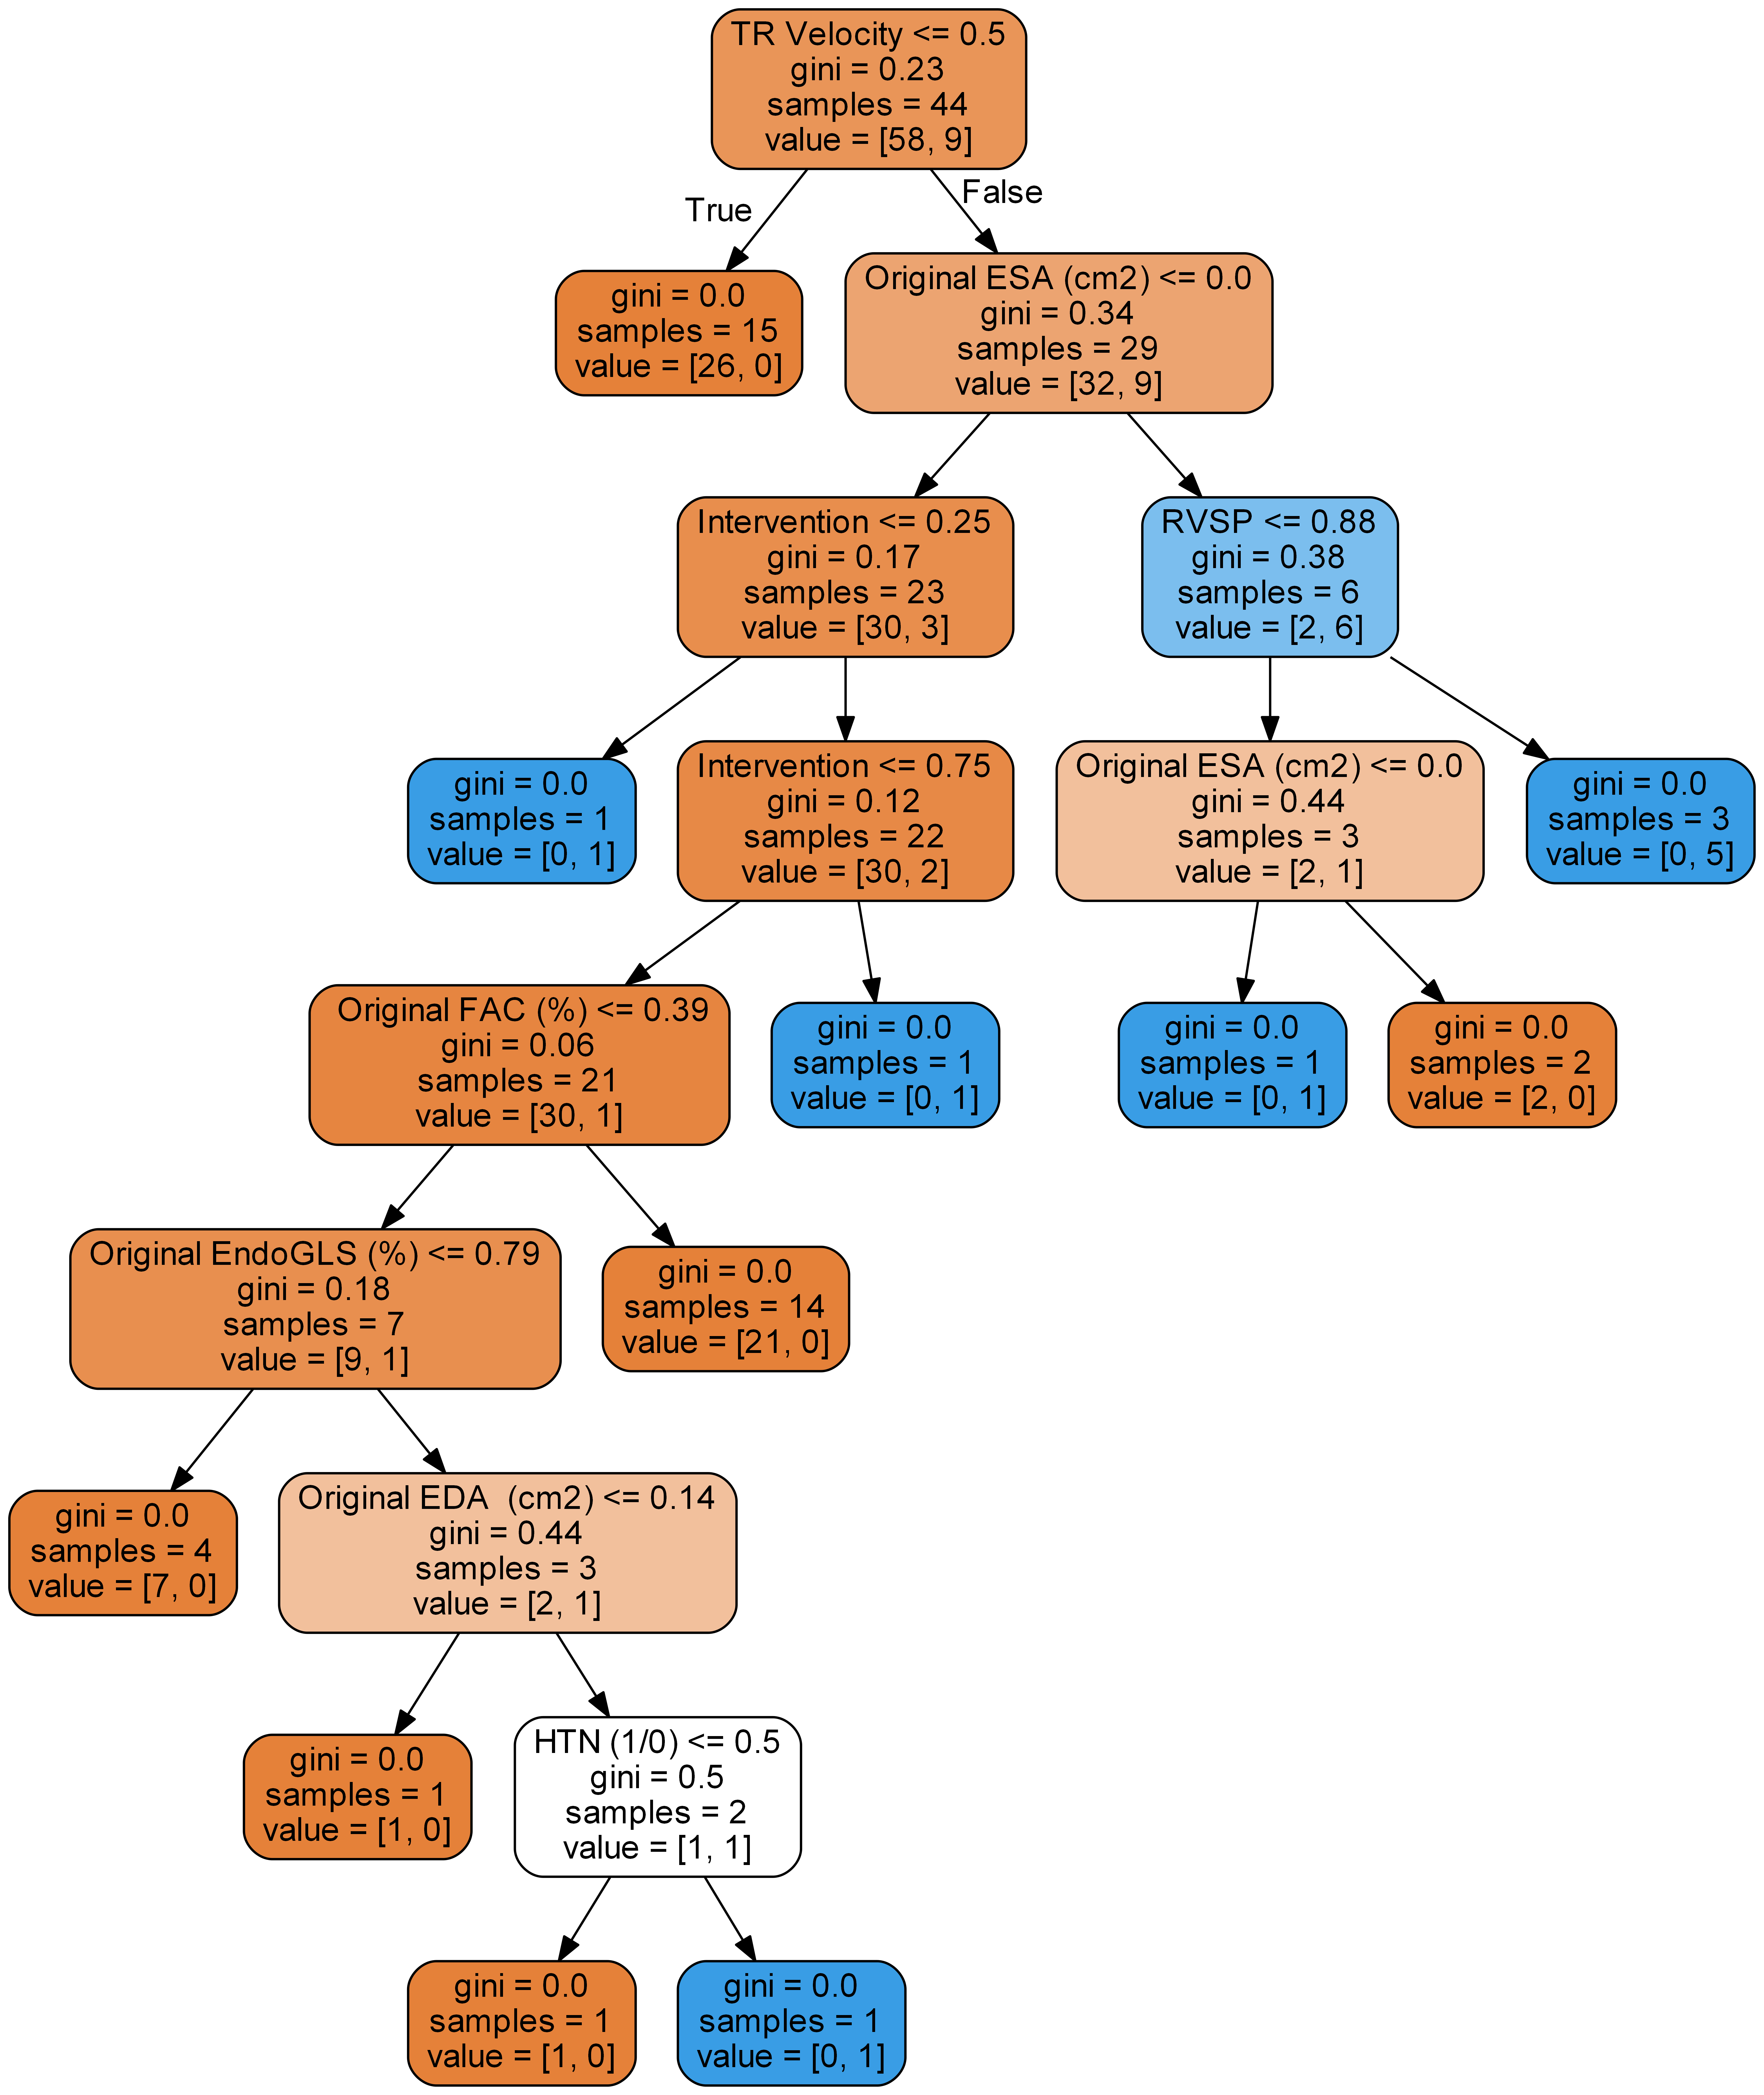

In [12]:
# Export as dot file

estimator = model.estimators_[5]

export_graphviz(estimator, out_file='tree.dot', 
                feature_names = cols,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)

from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook

from IPython.display import Image
Image(filename = 'tree.png')